In [1]:
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import sys
sys.path.append('../src')
import pandas as pd

import cv2
import numpy as np
import supervision as sv
from os.path import expanduser
import json
from unet_model import *
import segmentation_models_pytorch as smp
from scipy.spatial.distance import cdist
from strategies import *
from custom_datasets import *
import torch.optim as optim

In [2]:
home = expanduser("~")
main_path = home+"/Active-Learning-Segmentation/"
dataframes_path = main_path + "data/dataframes/"
sam_path = main_path + "sam/sam_vit_h_4b8939.pth"
notebooks_path = main_path + "scripts/notebooks/"
expirements_path = main_path+"expirements/"
processed_data_path = main_path + "data/processed/"
trained_models = main_path + "scripts/notebooks/trained_models/"
combinations_dataframe_path = dataframes_path + "comp_df.csv"
similarity_train_data_path = processed_data_path + "train_similarity/"

In [3]:
df_name = "lunar_df"
train_df = pd.read_csv(dataframes_path+"lunar_df_train.csv")
test_df = pd.read_csv(dataframes_path+"lunar_df_test.csv")
comp_df = pd.read_csv(dataframes_path+"comp_df.csv")

In [4]:
if not os.path.exists(similarity_train_data_path):
    os.makedirs(similarity_train_data_path)#

In [5]:
# with open("brain_params.json", "r") as f:
#     params = json.load(f)
# with open("lung_params.json", "r") as f:
#     params = json.load(f)

with open("lunar_params.json", "r") as f:
    params = json.load(f)

In [6]:
params

{'n_epoch': 35,
 'train_args': {'batch_size': 16, 'num_workers': 1},
 'test_args': {'batch_size': 512, 'num_workers': 1},
 'optimizer_args': {'lr': 0.005, 'momentum': 0.9},
 'use_sam': True,
 'use_predictor': True,
 'use_generator': False,
 'init_set_size': 100,
 'rounds': 15,
 'activate_sam_at_round': 1,
 'img_size': [128, 128],
 'voting': True,
 'pre_trained': False,
 'dataset': 'Lunar_Rocky_Landscape',
 'similarity_check': True,
 'dropout': True}

In [7]:
if params["init_set_size"] == len(train_df):
    params["training_type"] = "no_active"
elif not params["use_sam"]:
    params["training_type"] = "no_sam"
elif params["voting"]:
    params["training_type"] = "voters"
else:
    params["training_type"]="withSAM_NoVoting"

if params["training_type"] == "no_active":
    if params["pre_trained"]:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/no_active/pre_trained_Unet_{params["img_size"][0]}.pt'
    else:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/no_active/not_pre_trained_Unet_{params["img_size"][0]}.pt'
else:
    if params["pre_trained"]:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/{params["training_type"]}/pre_trained/{params["init_set_size"]}'
    else:
        params["model_path"] = f'{notebooks_path}trained_models/{params["dataset"]}/{params["training_type"]}/not_pre_trained/{params["init_set_size"]}'

notes = f'{params["training_type"]}_{params["init_set_size"]}'

if params["dropout"] and params["training_type"] != "voters":
    params["model_path"] = f'{params["model_path"]}_dropout'
    notes = f"{notes}_dropout"

params['test_set_size'] = len(test_df)
params['df'] = df_name
params['query_num'] = int(0.05 * params['init_set_size'])
if params['query_num'] == 0:
    params['query_num'] = 1
params["strategy"] = "MarginSampling"



if params["training_type"] == "voters":
    if params["similarity_check"]:
        params["model_path"] = f'{params["model_path"]}_dbscan'
        notes = f"{notes}_dbscan"
    if params["dropout"]:
        params["model_path"] = f'{params["model_path"]}_dropout'
    params["model_path"] = f'{params["model_path"]}/voters_{params["img_size"][0]}'
        

In [8]:
# params["model_path"]

In [9]:
# voters = [f'{params["model_path"]}_{params["rounds"]-1}/model_{i}.pt' for i in range(1,10)]
# voters.append(f'{params["model_path"]}_{params["rounds"]-1}/main_Unet.pt')

In [10]:
# test_df_slice = test_df[i:i+1]
test_df_slice = train_df[:100]
# def get_data(handler, train_df, test_df):
#     return Data(train_df["images"].to_list(), train_df["masks"].to_list(), test_df["images"].to_list(), test_df["masks"].to_list(), handler, img_size=params["img_size"], df=train_df, path= main_path+"/data/processed/", use_sam=params['use_sam'])

# data = get_data(Handler, test_df_slice, test_df_slice)
# data.initialize_labels(params["init_set_size"])

In [11]:
# model = UNet(n_channels=3, n_classes=1, bilinear=True)
# net = Net(model, params, device = torch.device("cuda"))

In [12]:
# sam = SAMOracle(checkpoint_path=sam_path, img_size=params["img_size"])

In [13]:
# def predict(net, model_state:str):
#     net.net.load_state_dict(torch.load(model_state))
#     net.clf = net.net.to(torch.device("cuda"))
#     mask = net.predict(data.get_test_data())[0]
#     mask = (mask.squeeze().cpu().sigmoid()> 0.5).float()
    
#     return mask

In [14]:
# def get_boxes(mask):
#     if torch.is_tensor(mask):
#         mask = mask.numpy()
#         mask = np.array(mask, np.uint8)
#     # _, thresh = cv2.threshold(mask, 0.5, 1, 0)
#     contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     cnts = []
#     for cnt in contours:
#         x,y,w,h = cv2.boundingRect(cnt)
#         box = np.array([x, y, x+w, y+h])
#         cnts.append(box)
#     return np.array(cnts)   

In [15]:
# tmp_masks = [predict(net, path) for path in voters]
# voters_masks =[]
# for j in range(len(tmp_masks[0])):
#     voters_masks.append([tmp_masks[i][j] for i in range(len(tmp_masks))])

In [16]:
# voters_boxes = [[get_boxes(mask) for mask in masks] for masks in voters_masks]

In [17]:
mask_paths = []
gt_paths =[]
mask_paths_remove=[]
for i in range(len(test_df_slice)):
    gt_mask= np.load(test_df_slice["masks"][i], allow_pickle=True)
    if gt_mask.sum()>0:
        for j in range(10):
            mask_paths.append(similarity_train_data_path + f"sam_{j}_" + os.path.basename(test_df_slice["masks"][i]))
            gt_paths.append(test_df_slice["masks"][i])
    # else:
    #     for j in range(10):
    #         mask_paths_remove.append(similarity_train_data_path + f"sam_{j}_" + os.path.basename(test_df_slice["masks"][i]))

In [18]:
# for path in mask_paths_remove:
#     os.remove(path)

In [19]:
# comp_df = pd.DataFrame({"mask":mask_paths,
#                       "gt_mask":gt_paths})

# comp_df.to_csv(dataframes_path+"comp_df.csv")

In [20]:
# # voters_sam =[[sam.get_mask(img_path=test_df_slice["images"][i], boxes=box).squeeze() for box in boxes]for i,boxes in enumerate(voters_dbscan_dropout_boxes)]
# voters_sam=[]
# for i,boxes in enumerate(voters_boxes):
#     tmp_sams=[]
#     for j,box in enumerate(boxes):
#         tmp_sam = sam.get_mask(img_path=test_df_slice["images"][i], boxes=box).squeeze()
#         tmp_sams.append(tmp_sam)
#         path = similarity_train_data_path + f"sam_{j}_" + os.path.basename(test_df_slice["masks"][i])
#         np.save(path, tmp_sam)

In [21]:
class SimEmbeddings(torch.nn.Module):
    def __init__(self, dim):
        super(SimEmbeddings, self).__init__()
        dim_2 = int(dim/2)
        self.layer1 = torch.nn.Linear(dim, dim_2)
        self.layer2 = torch.nn.Linear(dim_2, dim_2)
        self.layer3 = torch.nn.Linear(dim_2, 1, bias=False)
        self.layer4 = torch.nn.Linear(dim, 1, bias=False)
        # self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x1 = self.layer1(x)
        # print(x1.shape)
        x2 = self.layer2(x1)
        # print(x2.shape)
        x3 = self.layer3(x2)
        # print(x3.shape)
        x4 = self.layer4(torch.permute(x3,(0, 2, 1)))
        # print(x4.shape)
        return self.sigmoid(x4)
        # return self.relu(x4)

In [22]:
emb = SimEmbeddings(params["img_size"][0])

In [23]:
class SimNet:
    def __init__(self, sim_model, params):
        self.sim_model = sim_model
        self.params = params
        self.optimizer = optim.SGD(list(self.sim_model.parameters()),lr = 1e-5, momentum=0.9, weight_decay=1e-2)
        self.loss_fn = torch.nn.MSELoss()

    def get_similarity(self, masks, gt_masks):
        tp, fp, fn, tn = smp.metrics.get_stats(masks.long(), gt_masks.long(), mode="binary", threshold=0.5)
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        return iou

    def train(self, data):
        n_epoch = self.params['n_epoch']
        self.sim_model = self.sim_model.to("cuda")
        self.sim_model.train()
        
        loader = DataLoader(data, shuffle=True, batch_size=64)
        prog_bar = tqdm.tqdm(range(1, self.params["n_epoch"] + 1), ncols = 100, disable = False)
        for epoch in prog_bar:
            for batch_idx, (x, y) in enumerate(loader):
                x, y = x.cuda(), y.cuda()
                # self.optimizer.zero_grad()
                        
                predicted_similarity = self.sim_model(x).squeeze()
                gt_similarity = self.get_similarity(x,y).squeeze()
                loss = self.loss_fn(predicted_similarity, gt_similarity)                
                
                loss.backward(retain_graph=True)

                self.optimizer.step()
                
                prog_bar.set_postfix(loss=loss.item())

    def predict(self, mask_path):
        self.sim_model = self.sim_model.to("cuda")
        self.sim_model.eval()
        mask = torch.Tensor(np.load(mask_path, allow_pickle=True)).view(1,self.params["img_size"][0],self.params["img_size"][1]).cuda()
        return self.sim_model(mask)
        
        

In [24]:
class CustomImageDataset(Dataset):
    def __init__(self, comp_df, transform=None, target_transform=None):
        self.comp_df = comp_df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.comp_df)

    def __getitem__(self, index):
        image = torch.Tensor(np.load(self.comp_df["mask"][index], allow_pickle=True))
        label = torch.Tensor(np.load(self.comp_df["gt_mask"][index], allow_pickle=True))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [25]:
dataset = CustomImageDataset(comp_df=comp_df)

In [26]:
loader = DataLoader(dataset, batch_size=100, shuffle=True)


In [27]:
net = SimNet(sim_model=SimEmbeddings(params["img_size"][0]),
             params=params)

In [28]:
idx = 5
net.predict(comp_df["mask"][idx])

tensor([[[0.5016]]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [29]:
net.train(dataset)

100%|██████████████████████████████████████████████████| 35/35 [00:22<00:00,  1.55it/s, loss=0.0149]


In [30]:
idx = 5
net.predict(comp_df["mask"][idx])

tensor([[[0.7429]]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [31]:
mask = torch.Tensor(np.load(comp_df["mask"][idx], allow_pickle=True))
gt_mask = torch.Tensor(np.load(comp_df["gt_mask"][idx], allow_pickle=True))

In [32]:
# loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits = False)

In [33]:
# loss_fn(gt_mask.long(), mask.long())

In [34]:
net.get_similarity(mask,gt_mask)

tensor(0.6118)

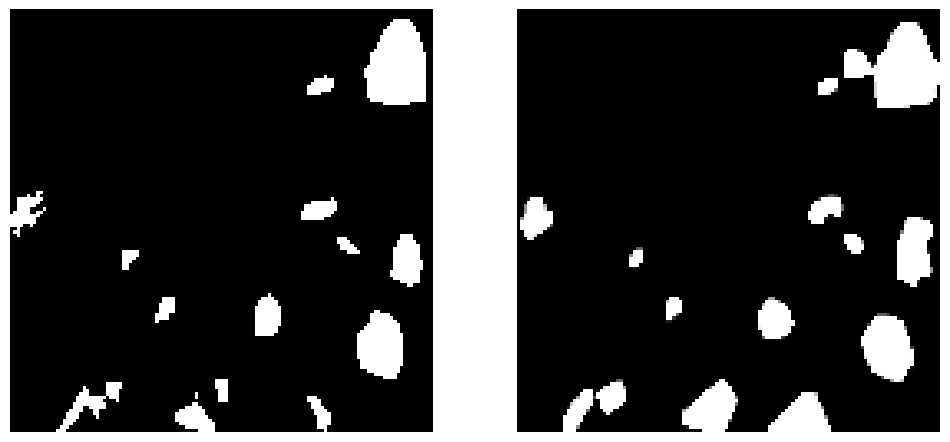

In [35]:
sv.plot_images_grid(
    images=[mask.cpu().numpy(), gt_mask.cpu().numpy()],
    grid_size=(1,2)
)